In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
# MNIST dataset

from torchvision import datasets, transforms
import torchvision

# Split MNIST into train, validation, and test sets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# Split train_data into train and validation sets
val_data = torch.utils.data.Subset(train_data, range(50000, 60000))
train_data = torch.utils.data.Subset(train_data, range(0, 50000))


In [3]:
# Create data loaders
batch_size = 1

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
img, target = next(iter(train_loader))
print(img.shape)
print(target.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1])


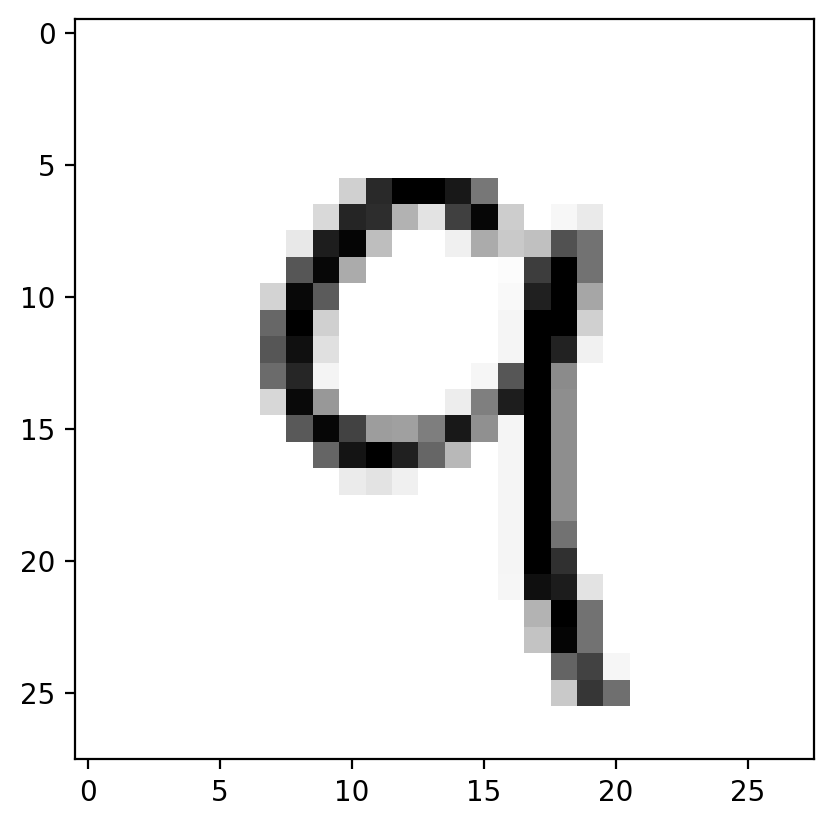

In [5]:
plt.imshow(img[0].numpy().squeeze(), cmap='gray_r');

In [6]:
target

tensor([9])

In [10]:
# Define model for 10-class MNIST classification

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        z1 = self.fc1(x)
        a1 = F.relu(z1)
        z2 = self.fc2(a1)
        a2 = F.relu(z2)
        z3 = self.fc3(a2) # logits
        return z3

In [11]:
model = MNISTClassifier()

# Get model summary
from torchsummary import summary
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          50,240
            Linear-2                [-1, 1, 32]           2,080
            Linear-3                [-1, 1, 10]             330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [15]:
# Forward pass through the model

img, target = next(iter(train_loader))
img = img.view(img.shape[0], -1)
print(img.shape)

out = model(img)
print(out)

# Softmax
probas = F.softmax(out, dim=1)
print(probas)

torch.Size([1, 784])
tensor([[-0.0570, -0.0891, -0.0610, -0.1264, -0.1313, -0.0712,  0.1441, -0.0798,
          0.0180,  0.0026]], grad_fn=<AddmmBackward0>)
tensor([[0.0985, 0.0954, 0.0981, 0.0919, 0.0915, 0.0971, 0.1204, 0.0963, 0.1062,
         0.1046]], grad_fn=<SoftmaxBackward0>)
